## Predict the probability of  Defaulters

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV ,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import joblib

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
#from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
#from sklearn.metrics import roc_auc_score, recall_score


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

label_encoder = preprocessing.LabelEncoder()

In [2]:
## Reading Data:
dataset = pd.read_csv('dataset - v2.csv')
dimension = pd.read_excel('data_dictionary_v1 .xlsx')
#dataset = OverallData[OverallData['label'] =='modeling'].reset_index(drop = True)
#oot_df = OverallData[OverallData['label'] == 'oot'].reset_index(drop = True)

# A. Exploratory Data Analysis:
    1. Identify the datatype, unique value and missing value counts for each column.
    2. Boxplot to find the outliers

# B. Data Preprocessing :
      1. Missing values:
          a. Carrier has network type infos so replacing NAs in network type with matching values like 4G.   
          b. Features which has outliers using median value to replace NAs.
          c. Features which represents frequencies of events using mode values to replace it.
          d. Features which represents amount type using mean values to replace NAs.
      2. Categorical values encoding:
          a. Label encoding
          b. Onehot encoding
      3. Standard scaling
      4. Pipeline for standardizing the codes.

# C. Feature Selection:
    1. pearson correlation coefficient.
    2. Permutation method.

# D. Building Model:
    1. Logisitic Regression classifier
    2. RandomForest classifier
    3. XGBoost classifier

# E. Hyperparameter tuning:
    1. GridSearchCV:
        i. The best classifier is  XGBoost among above three: Test Accuracy: 84.24% (+2.04% than base model)
    2. RandomizedSearchCV:
        i. The best classifier is XGBoost: Test Accuracy: 84.24%
        
    - There is no significant improvements in the accuracy in the RandomizedSearchCV compare to GridSearchCV.
    - Using XGBoostClassifier for the final prediction.
    

# F. Model Evaluation ( clf: Binary):
    1. Precision and Recall curve
    2. Confusion Matrix
    3. Accuracy
    4. ROC curve
    5. AUC

# G. Model Explainablity:
    1. SHAP Method
    2. LIME Method

In [3]:
## Summarizing: Metadata
feature_df = pd.DataFrame(data = {"feature_name" : [k for k in dataset.columns],
                                  "unqiue_val_cnt" : [dataset[k].nunique() for k in dataset.columns],
                                  "data_type" : [dataset[k].dtype for k in dataset.columns],
                                  'na_counts':[dataset[k].isna().sum() for k in dataset.columns],
                                 })
feature_df  = pd.merge(feature_df,dimension, how = 'left', left_on = 'feature_name', right_on = 'Rename')
feature_df.head(50)

,feature_name,unqiue_val_cnt,data_type,na_counts,Rename,description
0,decision_id,6246,object,0,NaN,NaN
1,label,2,object,0,NaN,NaN
2,default,2,float64,1585,NaN,NaN
3,v1,27,float64,1200,v1,# NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)
4,v2,5329,float64,238,v2,AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LAST 1...
5,v3,5217,float64,247,v3,AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS
6,v4,8,float64,314,v4,# RECHARGES LAST 150-180 DAYS
7,v5,430,float64,238,v5,count_debit_transactions_last_360_days
8,v6,4787,float64,628,v6,CUMULATIVE MAXIMUM BALANCE LAST 30 DAYS
9,v7,6,float64,314,v7,# RECHARGES WITH RECHARGE AMOUNTS MORE THAN 20...


In [4]:
feature_df['description'][4]

'AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LAST 180 DAYS'

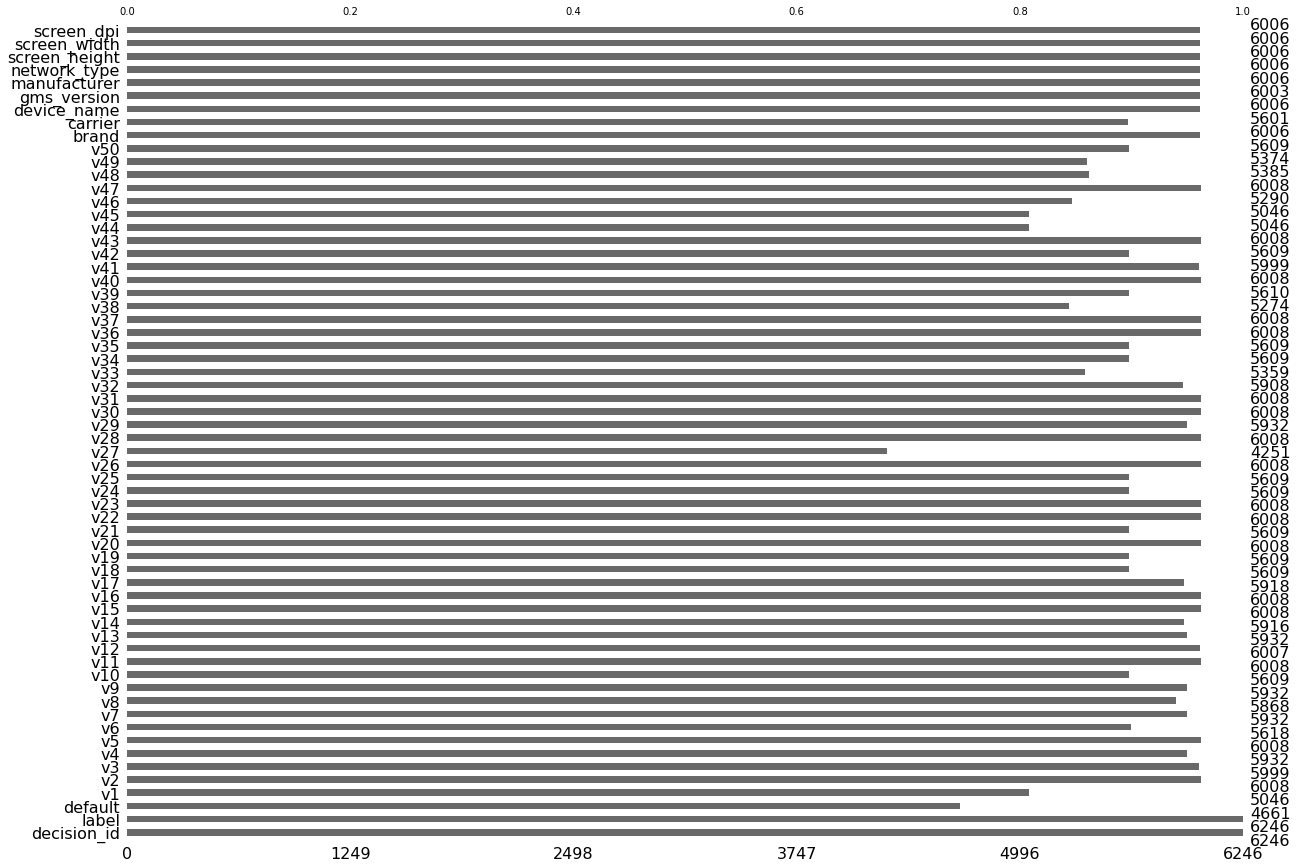

In [5]:
msno.bar(dataset, figsize=(20,15))
plt.show()

In [6]:
numParams = list(dataset.select_dtypes(include=np.number))
catparams = list(dataset.select_dtypes(exclude=np.number))

In [7]:
# Compute degree of skewness of data to figure out how to fill missing values:
## +ve value indicates that the distribution is skewed to the right (longer tail on the right side).
## -ve value skewness value indicates a left-skewed distribution (longer tail on the left side)
## 0 value indicates a symmetric distribution.
Skewness_score = dataset[numParams].skew()
Skewness_score

default           1.317124
v1                5.031099
v2               12.186532
v3               17.582365
v4                5.240334
v5                1.497382
v6               47.364621
v7                2.447445
v8               20.806948
v9                7.447425
v10              31.184611
v11               5.225291
v12              27.608730
v13               5.882680
v14              16.803811
v15              10.914501
v16               2.783229
v17               0.324766
v18               2.872981
v19              36.098533
v20              22.562246
v21              10.269569
v22              23.297254
v23              30.381069
v24              22.302651
v25              21.374608
v26               6.623498
v27              54.767977
v28              25.755013
v29               6.988355
v30              12.207891
v31               3.675239
v32              65.936426
v33              11.466241
v34               3.178453
v35               7.672562
v36               8.071139
v

In [8]:
## Re-verify outliers with help of Boxplot
def countplot_boxplot(column, df):
    fig = plt.figure(figsize=(15,18))
    fig.suptitle(column, size=20)
    ax1 = fig.add_subplot(2,2,1)
    sns.countplot(df[column])
    plt.xticks(rotation=45)
    
    ax2 = fig.add_subplot(2,2,2)
    sns.boxplot(df[column])
    plt.xticks(rotation=45)
    plt.show()

<AxesSubplot:xlabel='v6'>

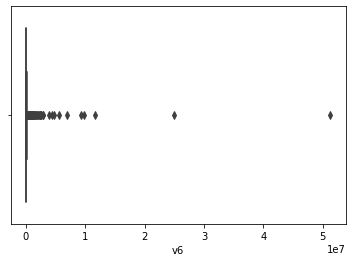

In [9]:
#Example:1 Field v6's(CUMULATIVE MAXIMUM BALANCE LAST 30 DAYS) skew score is 47. Which is highly skewed
# and it's boxplot looks like below:
#countplot_boxplot('v6',dataset)
sns.boxplot(dataset['v6'])

<AxesSubplot:xlabel='v5'>

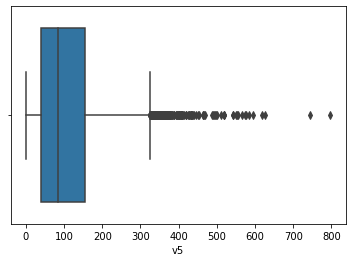

In [10]:
#Example:2 Field v5's(count_debit_transactions_last_360_days) skew score is 1.49. Which is more centered than v6
# and it's boxplot looks like below:
sns.boxplot(dataset['v5'])

In [11]:
#1. Hence using median to fill the missing values where skewness score >2.
#2. Mean for the skewness score <= 2
#3. And mode for the Boolean data type fields:

In [12]:
##  Functions to fill missing values with mode, median and mean respectively:
def fillna_mode(column, df):
    if column != 'default':
        df[column].fillna(df[column].mode()[0], inplace=True)

def fillna_median(column, df):
    if column != 'default':
        df[column].fillna(df[column].median(), inplace  = True)

def fillna_mean(column, df):
    if column != 'default':
        df[column].fillna(df[column].mean(), inplace = True)

In [13]:
# 1.1 Bool Data type: Create 'unknown' Category for the missing values
#   1. v18 : Other Loan
#   2. v34 : Gold Loan
cols_1 = ['v18', 'v34']
for col in cols_1:
    fillna_mode(col, dataset)

In [14]:
#2. Columns which has outliers i.e Skewness_score > 2
cols_2 = list(Skewness_score[Skewness_score >2].index)
for col in cols_2:
    fillna_median(col, dataset)

In [15]:
#3. Columns which has outliers i.e Skewness_score <= 2
cols_3 = list(Skewness_score[Skewness_score <=2].index)
for col in cols_3:
    fillna_mean(col, dataset)

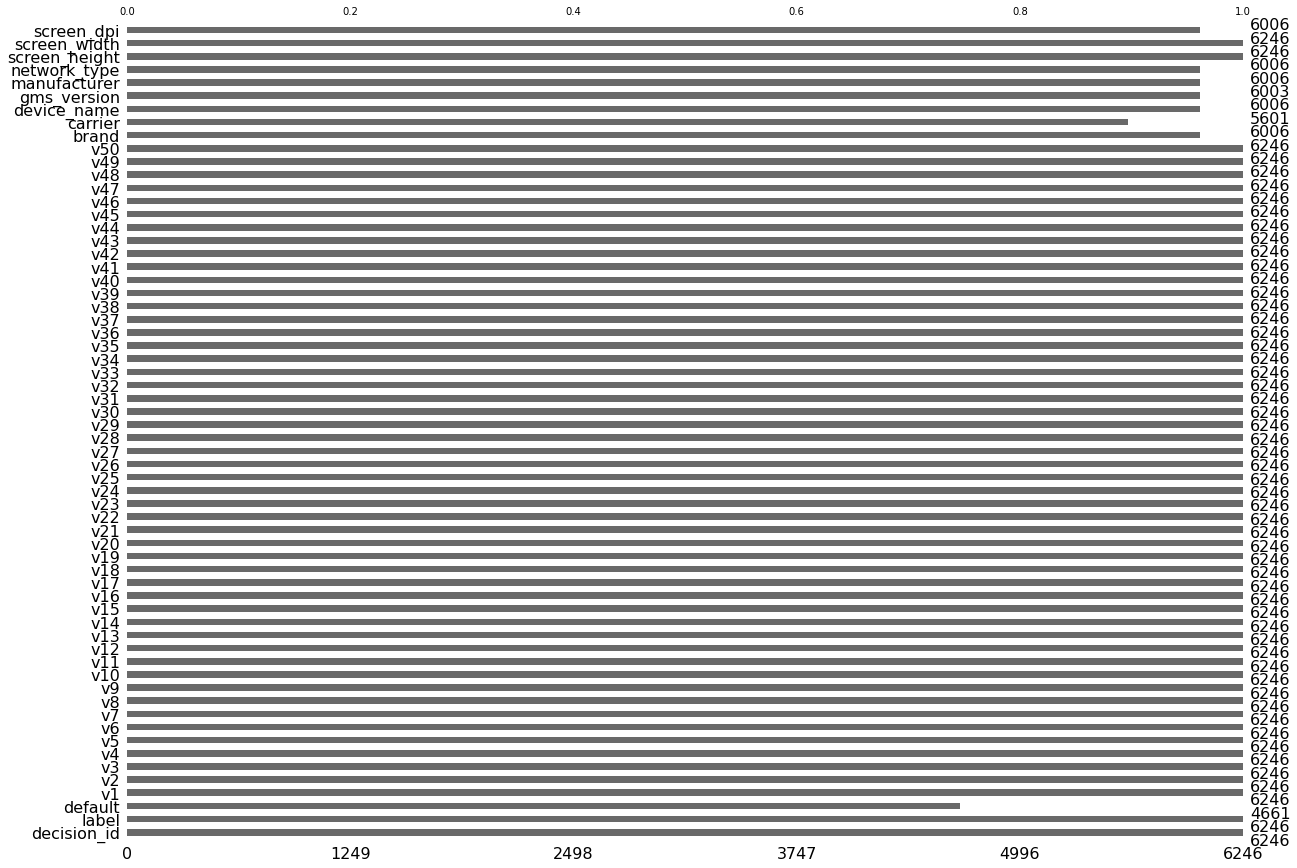

In [16]:
## After filling numerical columns missing values:
msno.bar(dataset, figsize=(20,15))
plt.show()

In [17]:
#5. Categorical data type:
feature_df[feature_df['data_type'] == 'object']

,feature_name,unqiue_val_cnt,data_type,na_counts,Rename,description
0,decision_id,6246,object,0,NaN,NaN
1,label,2,object,0,NaN,NaN
53,brand,168,object,240,NaN,NaN
54,carrier,46,object,645,NaN,NaN
55,device_name,636,object,240,NaN,NaN
56,gms_version,343,object,243,NaN,NaN
57,manufacturer,172,object,240,NaN,NaN
58,network_type,6,object,240,NaN,NaN
61,screen_dpi,5,object,240,NaN,NaN


Text(0, 0.5, 'Frequency')

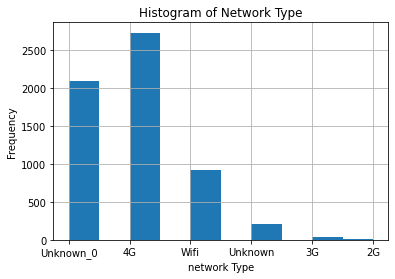

In [18]:
#5 Categorical Parameters:
##1. Network Type:
dataset['network_type'].hist()
plt.title('Histogram of Network Type')
plt.xlabel('network Type')
plt.ylabel('Frequency')

In [19]:
#1.1 The carrier columns have some information which are not clear in the network_type against'unknown' and 'unknown_0'
#1.2 Replacing 'unknown' and 'unknown_0' values in the network_type with the help of carrier column on if matching.
dataset['carrier'] = dataset['carrier'].str.lower()
dataset['network_type'] = dataset['network_type'].str.lower()

filter1 = dataset['network_type'].isin(['unknown','unknown_0'])
filter2 = dataset['carrier'].str.contains('4g')
idx = dataset[ filter1 & filter2 ].index
dataset.loc[idx, 'network_type'] = dataset.loc[idx, 'carrier']
dataset['network_type'].replace({'jio 4g | jio 4g':'4g', 'jio 4g':'4g'}, inplace = True)
dataset['network_type_new'] = label_encoder.fit_transform(dataset['network_type'])
#dataset['network_type_new'].value_counts()

Text(0, 0.5, 'Frequency')

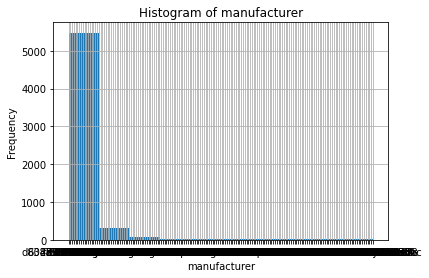

In [20]:
## 2. manufacturer:
dataset['manufacturer'].hist()
plt.title('Histogram of manufacturer')
plt.xlabel('manufacturer')
plt.ylabel('Frequency')

In [21]:
#2.1 Function to do customized label encoding:
def manufacturerLabelEncoding(x, manufacturer_dict):
    for key, value in manufacturer_dict.items():
        if x == key:
            return value

In [22]:
#2.2 Among the variety of manufacturers selecting top 9 and creating others for the remainings type
#2.3 Created a dictionary to store manufacturer's name and corresponding encoded values:
manufacturer_dict = {'vivo':0, 'xiaomi':1, 'samsung':2, 'oppo':3, 'realme':4, '638b5f4f86dfed5d':5,'oneplus':6, 'huawei':7, 'motorola':8}
dataset['manufacturer'] = dataset['manufacturer'].str.lower()
dataset.groupby(['manufacturer']).count().reset_index().iloc[ :,0:2].sort_values(by='decision_id',ascending = False).head(10)
dataset['manufacturer_new'] = dataset['manufacturer'].apply(lambda x: manufacturerLabelEncoding(x, manufacturer_dict))
dataset['manufacturer_new'] = dataset['manufacturer_new'].fillna(9)
#dataset['manufacturer_new'].value_counts()

In [23]:
#3. carrier:
#3.1 Function to clean up the carrier text:
def carrierCleanup(x):
    if 'jio' in x:
        return 'jio'
    elif 'airtel' in x:
        return 'airtel'
    ## Considering vodafone, idea and vi are three different entities
    elif 'vodafone' in x :
        return 'vodafone'
    elif 'idea' in x or '!dea' in x:
        return 'idea'
    elif 'bsnl' in x or 'cellone' in x:
        return 'bsnl'
    elif 'vi' in x:
        return 'vi'
    else:
        return 'others'

In [24]:
#3.2 Label encoding for carriers:
dataset['carrier_new'] = dataset['carrier'].apply(lambda x: carrierCleanup(str(x)))
dataset['carrier_new'] = label_encoder.fit_transform(dataset['carrier_new'])
#dataset['carrier_new'].value_counts()

In [25]:
#4.brand
#4.1 Label encoding for brand values
dataset['brand'] = dataset['brand'].str.lower()
dataset['brand_new'] = label_encoder.fit_transform(dataset['brand'])

In [26]:
#5. device_name:
#5.1 Label encoding for device_name:
dataset['device_name'] = dataset['device_name'].str.lower()
dataset['device_name_new'] = label_encoder.fit_transform(dataset['device_name'])

In [27]:
#6. gms_version
dataset['gms_version_new'] = label_encoder.fit_transform(dataset['gms_version'])

In [28]:
#7.screen_dpi
#7.1 one hot encoding for screen_dpi:
dataset['screen_dpi'] = dataset['screen_dpi'].fillna('others')
onehot_encoded = pd.get_dummies(dataset[['decision_id','screen_dpi']], columns=['screen_dpi'])

In [29]:
dataset_new =  pd.merge(dataset, onehot_encoded, how='left', on = 'decision_id')
processed_DF = dataset_new.drop(columns=['brand', 'carrier', 'device_name','gms_version',
                        'manufacturer', 'network_type','screen_dpi'], axis=1)

In [30]:
dataset.shape

(6246, 68)

<AxesSubplot:>

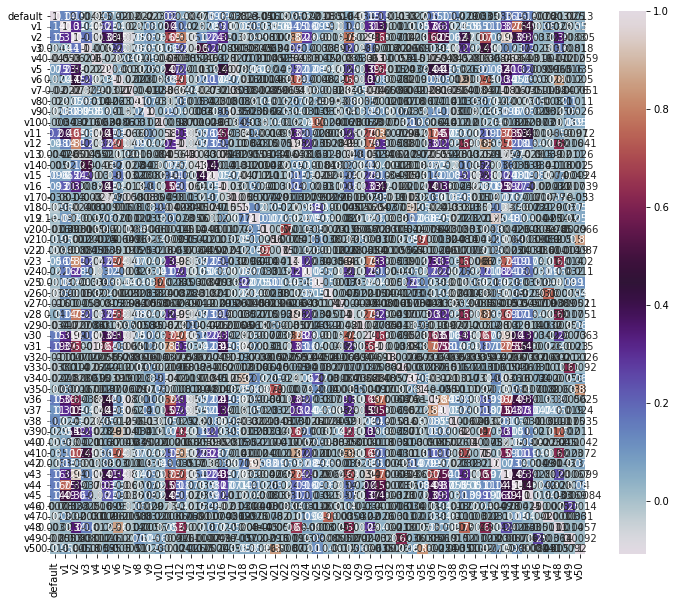

In [31]:
## Checking Multicollinearity:
#Plotting a correlation matrix
colnames = ['label', 'default', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v50',]
plt.figure(figsize = (12,10))
corr = dataset[colnames].corr()
sns.heatmap(corr, annot = True, cmap = 'twilight')

In [32]:
#1. Feature Selections using pearson correlatiopn coefficinet:
corr = processed_DF.corr()['default'].sort_values(ascending=False)[1:]
abs_corr = abs(corr)
#abs_corr.sort_values(ascending=False)
relevant_features = abs_corr[abs_corr>0.05]
relevant_features.sort_values(ascending=False)

gms_version_new      0.276276
v11                  0.202529
v31                  0.194262
brand_new            0.181378
v44                  0.155725
v43                  0.155643
v36                  0.152819
manufacturer_new     0.152818
v30                  0.152716
v2                   0.147630
v45                  0.141422
v1                   0.136157
screen_dpi_others    0.134142
v38                  0.121596
carrier_new          0.118005
v37                  0.106688
v15                  0.096496
v16                  0.093062
device_name_new      0.091633
v5                   0.075134
screen_dpi_xhdpi     0.070526
screen_width         0.062718
screen_dpi_hdpi      0.060610
screen_height        0.059513
v23                  0.056303
Name: default, dtype: float64

In [33]:
newCols = ['decision_id','default']
for col in relevant_features.index:
    newCols.append(col)
    
processedDF_corr = processed_DF[newCols]

In [34]:
## Permutation method: changes the data in a column and then tests how much that affects the model accuracy.
    # If changing the data in a column drops the accuracy, then that column is assumed to be important
from sklearn.inspection import permutation_importance

def get_permutation_importance(X, y, model):
    colnames = X.columns
    result = permutation_importance(model, X, y, n_repeats=1, random_state=0)
    
    # permutational importance results
    result_df = pd.DataFrame(colnames,  columns=['Feature'])
    result_df['permutation_importance'] = result.get('importances')
    
    return result_df

In [35]:
processed_DF = processed_DF.fillna(0)
train_dataset = processed_DF[processed_DF['label'] == 'modeling']

y = train_dataset['default']
X = train_dataset.drop(['default','decision_id', 'label'], axis =1)
n =  processed_DF.shape[1]-2

In [36]:
lr = LogisticRegression(random_state=7)
lr.fit(X,y)
relevant_features = get_permutation_importance(X, y, lr)
relevant_features.sort_values('permutation_importance', ascending=False)[
                            ['Feature','permutation_importance']][:20].style.background_gradient(cmap='Blues')

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Feature,permutation_importance
29,v30,0.219266
1,v2,0.108775
22,v23,0.097833
5,v6,0.064793
27,v28,0.045913
42,v43,0.032182
2,v3,0.020167
40,v41,0.004505
14,v15,0.003218
38,v39,0.002575


In [37]:
# Consideering permutation_importance threshold > 0
relevant_features = relevant_features[relevant_features['permutation_importance']> 0]
relevantCols = list(relevant_features['Feature'])
relevant_features

,Feature,permutation_importance
1,v2,0.108775
2,v3,0.020167
5,v6,0.064793
9,v10,0.000858
13,v14,0.002145
14,v15,0.003218
22,v23,0.097833
26,v27,0.000215
27,v28,0.045913
29,v30,0.219266


In [38]:
newCols = ['decision_id','default']
for col in relevantCols:
    newCols.append(col)
    
processedDF_pi = train_dataset[newCols]

In [39]:
processedDF_pi.columns

Index(['decision_id', 'default', 'v2', 'v3', 'v6', 'v10', 'v14', 'v15', 'v23',
       'v27', 'v28', 'v30', 'v38', 'v39', 'v41', 'v43', 'v46'],
      dtype='object')

<AxesSubplot:>

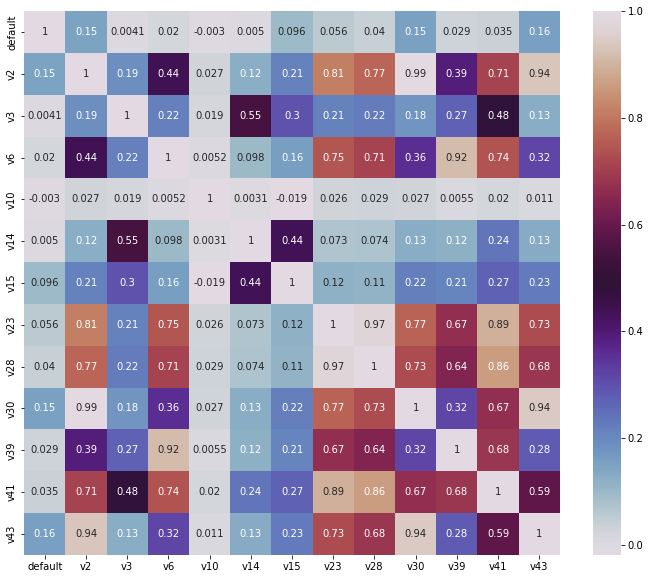

In [40]:
#Plotting a correlation matrix
plt.figure(figsize = (12,10))
corr = processedDF_pi[['default', 'v2', 'v3', 'v6', 'v10', 'v14', 'v15', 'v23',
       'v28', 'v30', 'v39', 'v41', 'v43']].corr()
sns.heatmap(corr, annot = True, cmap = 'twilight')

# 2.Building Model

In [41]:
# Splitting the preprocessed data into train and test:
processedDF_pi = processedDF_pi.fillna(0)
y = processedDF_pi['default']
X = processedDF_pi#.drop(['default','decision_id'], axis =1)
val_dataset = processed_DF[processed_DF['label'] == 'oot']

n =  processedDF_pi.shape[1]-2
seed = 7
test_size = 0.20

# apply the log transformation to the features
# log_transformer = FunctionTransformer(np.log)
# X_log = log_transformer.transform(X_)
# X_log.replace([np.inf, -np.inf], 0, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

X_train_new = X_train.copy()
X_train = X_train.drop(['default','decision_id'], axis =1)
X_test = X_test.drop(['default','decision_id'], axis =1)

In [42]:
# Pipeline for Logistic regression:
pipeline_lr = Pipeline([('scalar1',StandardScaler()),
                        ('pca1',PCA(n_components= n)),
                        ('lr_classifier',LogisticRegression(random_state=7))])

# Pipeline for Random Forest:
pipeline_rf = Pipeline([('scalar2',StandardScaler()),
                        ('pca2',PCA(n_components= n)),
                        ('rf_classifier',RandomForestClassifier(random_state=7))])

# Pipeline for XGBoost:
pipeline_xgb = Pipeline([('scalar3',StandardScaler()),
                        ('pca3',PCA(n_components= n )),
                        ('rf_classifier',XGBClassifier(random_state=7))])

In [43]:
best_pipeline = ''
best_classifier = 0
best_accuracy = 0

pipelines = [pipeline_lr, pipeline_rf, pipeline_xgb]
# pipeline disctionary:
pipe_dict = {0: 'Logistic Regression', 1: 'RandomForest', 2: 'XGBoost'}

# Fitting the pipelines for the above three model
for pipe in pipelines:
    pipe.fit(X_train, y_train)

/home/ubuntu/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:31:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
for k, model in enumerate(pipelines):
    print("{} test accuracy: {}".format(pipe_dict[k],model.score(X_test,y_test)))

Logistic Regression test accuracy: 0.7888531618435155
RandomForest test accuracy: 0.8006430868167203
XGBoost test accuracy: 0.7845659163987139


In [45]:
for k, model in enumerate(pipelines):
    if model.score(X_test,y_test) > best_accuracy:
        best_accuracy = model.score(X_test,y_test)
        best_pipeline = model
        best_classifier = k
print('Classifier with the best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with the best accuracy:RandomForest


In [46]:
logreg_model =  pipeline_lr.fit(X_train, y_train)

In [47]:
for k , model in enumerate(pipelines):
    print("Model Name:", k)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

Model Name: 0
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88       726
         1.0       0.62      0.12      0.20       207

    accuracy                           0.79       933
   macro avg       0.71      0.55      0.54       933
weighted avg       0.76      0.79      0.73       933

Accuracy: 78.89%
Model Name: 1
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88       726
         1.0       0.60      0.30      0.40       207

    accuracy                           0.80       933
   macro avg       0.71      0.62      0.64       933
weighted avg       0.78      0.80      0.77       933

Accuracy: 80.06%
Model Name: 2
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87       726
         1.0       0.53      0.29      0.38       207

    accuracy                           0.78       933
   macro avg       0.67      0.61      0.62       93

# Hyper parameters tunning

In [48]:
%%time
# Create a pipeline
pipe = Pipeline([("clf", RandomForestClassifier())])

# Grid params disctionary: Classifiers and the respective parameters and value range
grid_param = [
                {"clf": [LogisticRegression()],
                 "clf__penalty": ['l2'],
                 "clf__C": np.logspace(0, 4, 10), # C : inverse of regularization smaller, values specify stronger regularization.
                 "clf__solver":['liblinear','saga','newton-cg'], # Doesn't allow L1 penanlty.
                 "clf__max_iter":[100, 500, 1000]
                 },
                {"clf": [RandomForestClassifier()],
                 "clf__criterion":['gini', 'entropy', 'log_loss'], #The function to measure the quality of a split.
                 "clf__n_estimators":[100, 500, 1000], # No. of trees
                 "clf__max_depth":[5,8,15,25,30,None], # The maximum depth of the tree
                 "clf__min_samples_leaf":[1,2,5,10,15,100], # The minimum number of samples required to split an internal node
                 "clf__max_leaf_nodes": [2, 5,10]   #Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity
                }, 
                {"clf": [XGBClassifier()], #use_label_encoder=False
                 "clf__objective":["binary:logistic",'binary:hinge'],
                 "clf__eval_metric":['logloss'],
                 "clf__learning_rate":[0.02,0.05, 0.08,0.1],
                 "clf__n_estimators":[100,500],
                 "clf__max_depth":[4,5,6],
                 "clf__subsample":[0,1], #Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
                 "clf__tree_method":['auto', 'hist',], #'exact', 'approx',
                 "clf__num_parallel_tree":[4,6]
                 #"clf__reg_lambda":[0,1,2],   #L2 regularization term on weights. Increasing this value will make model more conservative.
                 }]

CPU times: user 692 µs, sys: 0 ns, total: 692 µs
Wall time: 699 µs


In [52]:
log_transformer = FunctionTransformer(np.log)
X_train_log = log_transformer.transform(X_train)
X_test_log = log_transformer.transform(X_test)

X_train_log.replace([np.inf, -np.inf], 0, inplace=True)
X_test_log.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
X_train_log

In [53]:
%%time
## 
randomizedSCV = RandomizedSearchCV(pipe, param_distributions = grid_param, n_iter = 1,
                                   n_jobs = -1, cv = 5,verbose = 0)
model_rscv = randomizedSCV.fit(X_train_log,y_train)
y_pred = model_rscv.predict(X_test_log)
print(" Accuracy:",accuracy_score(y_test, y_pred)*100)

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/hom

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [51]:
#Saving model:
filename = 'model_rscv.joblib.pkl'
joblib.dump(model_rscv, filename)
model_rscv = joblib.load(filename)
model_rscv.best_estimator_

NameError: name 'model_rscv' is not defined

# Model Evaluation:

In [ ]:
# ROC-curve and AUC:
y_pred_proba = model_rscv.predict_proba(X_test_log)
y_pred_prob = y_pred_proba[:,1]

# Computing false positive and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC:',auc(fpr, tpr))

In [ ]:
# Confusion Matrix:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['False', 'True'])
cm_display.plot()
plt.show()

In [ ]:
## Precision , Recall, F1-Score and accuracy:
y_pred = np.where(y_pred_prob >0.5, 1,0)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## Handling Imbalanced data
    # Under-sampling
    # Over-sampling
    # SMOTE

In [ ]:
%%time
# Under-sampling:
count_class_0 = X_train_new.default.value_counts()[0]
count_class_1 = X_train_new.default.value_counts()[1]
#processedDF_pi.default.value_counts()[1]
df_class_0 = X_train_new[X_train_new['default'] == 0]
df_class_1 = X_train_new[X_train_new['default'] == 1]
df_class_0_under = df_class_0.sample(count_class_1)
df_train_set = pd.concat([df_class_0_under, df_class_1], axis =0)
df_test_set = df_train_set['default']
df_train_set.drop(['default','decision_id'], axis =1, inplace = True)
rscv_undersample = randomizedSCV.fit(df_train_set,df_test_set)

## Precision , Recall, F1-Score and accuracy:
y_pred = rscv_undersample.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
%%time
# Over-sampling:
count_class_0 = X_train_new.default.value_counts()[0]
count_class_1 = X_train_new.default.value_counts()[1]

#processedDF_pi.default.value_counts()[1]
df_class_0 = X_train_new[X_train_new['default'] == 0]
df_class_1 = X_train_new[X_train_new['default'] == 1]
df_class_1_over = df_class_1.sample(count_class_0, replace = True)
df_train_set = pd.concat([df_class_1_over, df_class_0], axis =0)
df_test_set = df_train_set['default']
df_train_set.drop(['default','decision_id'], axis =1, inplace = True)
rscv_oversample = randomizedSCV.fit(df_train_set,df_test_set)

# Precision , Recall, F1-Score and accuracy:
y_pred = rscv_oversample.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after over sampling: %.2f%%" % (accuracy * 100.0))

In [ ]:
%%time
# Synthetic Minority oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE()
df_train_set, df_test_set = smote.fit_resample(X_train, y_train)
df_test_set.value_counts()
rscv_smote = randomizedSCV.fit(df_train_set,df_test_set)

# Precision , Recall, F1-Score and accuracy:
y_pred = rscv_smote.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after over sampling: %.2f%%" % (accuracy * 100.0))

In [ ]:
# Confusion Matrix:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['False', 'True'])
cm_display.plot()
plt.show()

## Computing Inferences:

In [ ]:
inference_df = val_dataset.reset_index(drop = True)
decision_id = inference_df['decision_id']
inference_df = inference_df[X_test.columns]
inference =  rscv_smote.predict(inference_df)
unique, counts = np.unique(inference, return_counts=True)
unique,counts

In [ ]:
default_inference = pd.DataFrame(inference, columns =['default_inference'])
Final_result = pd.concat([decision_id, default_inference], axis = 1)
Final_result.to_csv('Final_result.csv')

In [ ]:
inference_df.shape

# Rough Work

In [ ]:
#1.2 Not sure what to do with the -ve values. To process it need more details about ther fields.
#1.3 Checking for the outlies:

# for k in dataset.columns:
#     if dataset[k].dtype == 'float64':
#         countplot_boxplot(k, dataset)

In [ ]:
# for k in dataset.columns:
#     if dataset[k].dtype == 'float64':
#         print("{} |{} | {} |{} | {} | {}".format(k ,dataset[k].min(), dataset[k].max(), 
#                                         dataset[k].mean(), dataset[k].median(),
#                                         dataset[k].mode()))
# Cols| min | Max | mean | Median | mode


In [ ]:
#chaid_clf = DecisionTreeClassifier(criterion='entropy')

# fs = SelectKBest(score_func=f_regression, k = 15)
# # apply feature selection
# X_selected = fs.fit_transform(X, y)
# print(X_selected.shape)

# logreg = LogisticRegression(random_state = 7, max_iter = 300, penalty = 'l1', solver = 'liblinear',C = 0.2)
# logreg.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
#y_pred_proba = logreg.predict_proba(X_test)


# rf_model = RandomForestClassifier(n_estimators = 500, 
#                                   bootstrap=True , random_state = 7)

In [ ]:
# X_set, y_set = X_test, y_test
# X1, X2 = np.meshgrid(np.arange(start = X_set.iloc[:, 0].min() - 1, 
#         stop = X_set.iloc[:, 0].max() + 1, step = 0.01), np.arange(start = X_set.iloc[:, 1].min() - 1,
#         stop = X_set.iloc[:, 1].max() + 1, step = 0.01))

# plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), 
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))

# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())

# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
#     c = ListedColormap(('red', 'green'))(i), label = j)
#     plt.title('Classifier (Test set)')
#     plt.xlabel('Age')
#     plt.ylabel('Estimated Salary')
#     plt.legend()
#     plt.show()

In [ ]:
%%time
# GridSearchCV Train
#best_model_grid
# create a gridsearch of the pipeline, the fit the best model
# gridsearch = GridSearchCV(pipe, grid_param, cv = 5, verbose = 0,n_jobs = -1) # Fit grid search
# best_model_grid = gridsearch.fit(X_train,y_train)
# best_model_grid.score(X_test,y_test)
# best_model_grid.best_estimator_

In [ ]:
# ## Given the imbalanced dataset trying to optimise positive weight (minor class).
# pos_ratio = {}
# valcounts = y.value_counts(normalize=False)
# pos_ratio = 1.0*valcounts[1]/valcounts[0]
# pos_frac = pos_ratio/(1+pos_ratio)

# xgb_tuned = XGBClassifier(booster='gbtree', eval_metric='logloss', learning_rate=0.01,
#               max_depth=3, min_child_weight=1,n_estimators=1000, n_jobs= 3,
#               num_parallel_tree=3, predictor='auto', random_state=0, scale_pos_weight= 0.5*1/pos_ratio,
#               base_score = 0.5*pos_frac, tree_method='auto')

# xgb_tuned.fit(X_train,y_train)
# y_pred = xgb_tuned.predict(X_test)
# print("Positive weight scaled model accuracy is:",accuracy_score(y_test, y_pred)*100)

In [ ]:
# # Precision-Recall Curve:
# from sklearn.metrics import PrecisionRecallDisplay

# display = PrecisionRecallDisplay.from_estimator(model_rscv, X_test, y_test, name="XGBClassifier"
# )
# _ = display.ax_.set_title("2-class Precision-Recall curve")